# PATMOS-x v06r00 time series from monthly means

Monthly means for PATMOS-x v06r00 data have been computed with the script [PATMOS-x_monthlymean.py](../scripts/PATMOS-x_monthlymean.py). The monthly means are computed at the pixel level. That is, the monthly mean for a given variable is a 3D array of coordinates `(time, latitude, longitude)`. Here, `time` is a `datetime64[ns]` which indicates the month.

The monthly means have been computed for the following variables:
- `cloud_probability`
- `cloud_fraction`
- `tiwp`

Notes:
- Concerning `cloud_fraction`, based on https://doi.org/10.3390/rs8060511, which is not the [official documentation](https://www.ncei.noaa.gov/pub/data/sds/cdr/CDRs/AVHRR-HIRS_Cloud_Properties_PATMOS-x/AlgorithmDescription/AlgorithmDescription_ACHA_01B-1d.pdf) (it says very little), it is obtained by:
  1. Centering an array of 3x3 pixels of the native satellite on the PATMOS-x pixel.
  2. Determining if the native pixel is cloudy based on `cloud_probability > 0.5` computed for the native pixel.
  3. Taking the average of the 3x3 boolean array.

  The `cloud_fraction` can be observed as a mean cloud probability ([source](https://doi.org/10.1175/JAMC-D-11-02.1)).

- `tiwp` is obtained by considering the cloud water path of those pixels which are indicated to have an ice cloud phase.

  - PATMOS-x lists `mixed` as a possible cloud phase, but it is never observed in the data prepared.

- The cloud water paths are computed using the DCOMP (daytime-only) algorithm.

- PATMOS-x has a constant spatial grid.

- The monthly means files contain the variables `var_count`, e.g. `cloud_fraction_count`, which indicate how many values were used to compute the average for every pixel.

Based on the last point, there are two options when summarizing the values as one value per month:
- Type I average: average of averages.
  - 1: Compute the monthly average for each pixel
  - 2: Weighted average of these pixelwise monthly averages (weights: $\cos(\text{latitude})$)
- Type II average: average all values.
  - 1: Weighted average all values in the month (weights: $\cos(\text{latitude})$)

I am not aware if 'type I' and 'type II' are standards. The nomenclature is irrelevant.

In [1]:
# Load libraries
import datetime
from pathlib import Path

import cartopy.crs as ccrs
import cmocean
from dask.diagnostics import ProgressBar
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm
import xarray as xr

plt.style.use("../ccic.mplstyle")

In [2]:
# Get monthly means file
mm_files = sorted(list(Path('/scratch/ccic_record/data/PATMOS-x/means/monthly_means').glob('PATMOS-x_v06-monthlymean_*zarr')))

# Assert all files expected are there
month_start = mm_files[0].stem.split('_')[-1]
month_end = mm_files[-1].stem.split('_')[-1]
datetime_start = datetime.datetime.strptime(month_start, '%Y%m')
datetime_end = datetime.datetime.strptime(month_end, '%Y%m')
n_months_expected = (datetime_end.year - datetime_start.year) * 12 + datetime_end.month - datetime_start.month + 1
n_months_found = len(mm_files)
assert n_months_expected == n_months_found

In [3]:
# Open the files (not loaded into memory)
ds = xr.open_mfdataset(mm_files, engine='zarr')

In [4]:
year = [pd.Timestamp(t).year for t in ds.time.data]
month = [pd.Timestamp(t).month for t in ds.time.data]

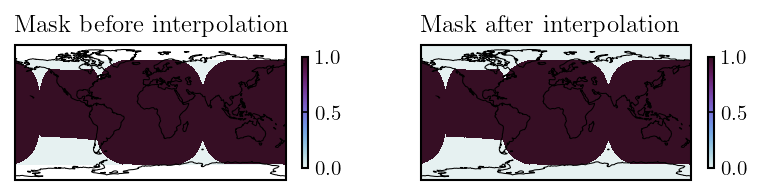

In [5]:
# Prepare the mask to use by resampling to the PATMOS-x coordinates
mask = xr.load_dataset('/scratch/ccic_record/data/mask_24.nc').mask

fig, axs = plt.subplots(ncols=2, subplot_kw=dict(projection=ccrs.PlateCarree()))

lons, lats = np.meshgrid(mask.longitude.data, mask.latitude.data)
m0 = axs[0].pcolormesh(lons, lats, mask, transform=ccrs.PlateCarree(), rasterized=True)
axs[0].coastlines()
axs[0].set_global()
axs[0].set_title('Mask before interpolation')
fig.colorbar(m0, ax=axs[0], shrink=0.2)


mask = mask.astype(int).interp(
    {
        'latitude': ds.latitude.data,
        'longitude': ds.longitude.data
    },
    method='nearest'
) == 1 # .astype(bool) doesn't work, since NaNs are converted to True


lons, lats = np.meshgrid(mask.longitude.data, mask.latitude.data)
m1 = axs[1].pcolormesh(lons, lats, mask, transform=ccrs.PlateCarree(), rasterized=True)
axs[1].coastlines()
axs[0].set_global()
axs[1].set_title('Mask after interpolation')
fig.colorbar(m1, ax=axs[1], shrink=0.2)

fig.savefig('../figures/PATMOSx_mask.pdf', bbox_inches='tight')
fig.savefig('../figures/PATMOSx_mask.png', dpi=300, bbox_inches='tight')

plt.show()

In [6]:
# Save the mask to a results dataset
ds_results = xr.Dataset(
    data_vars={
        'mask': (('latitude', 'longitude'), mask.data)
    },
    coords={
        'latitude': ('latitude', mask.latitude.data),
        'longitude': ('longitude', mask.longitude.data)
    }
)

## Average maps of the different variables

In [7]:
# First: add values to results dataset

# Take into account the number of points available for each pixel
full_weighted_average = lambda var: ds[var].weighted(ds[f"{var}_count"]).mean(dim='time', skipna=True).values

ds_results = ds_results.merge(
    xr.Dataset(
        data_vars={
            'cloud_probability_fullaverage': (
                ('latitude', 'longitude'),
                full_weighted_average('cloud_probability'),
                {'period': f'{month_start}-{month_end}'}
            ),
            'cloud_fraction_fullaverage': (
                ('latitude', 'longitude'),
                full_weighted_average('cloud_fraction'),
                {'period': f'{month_start}-{month_end}'}
            ),
            'tiwp_fullaverage': (
                ('latitude', 'longitude'),
                full_weighted_average('tiwp'),
                {
                    'period': f'{month_start}-{month_end}',
                    'units': ds.tiwp.units
                }
            ),            
        },
        coords={
            'latitude': ('latitude', ds.latitude.data),
            'longitude': ('longitude', ds.longitude.data)
        }
    )
)

/tmp/ipykernel_2583837/4051488987.py:16: UserWarning: Rasterization of '<cartopy.mpl.contour.GeoContourSet object at 0x72dd0b858be0>' will be ignored
  m_cloud_probability.set_rasterized(True)
/tmp/ipykernel_2583837/4051488987.py:30: UserWarning: Rasterization of '<cartopy.mpl.contour.GeoContourSet object at 0x72dd0977f370>' will be ignored
  m_cloud_fraction.set_rasterized(True)
/tmp/ipykernel_2583837/4051488987.py:46: UserWarning: Rasterization of '<cartopy.mpl.contour.GeoContourSet object at 0x72dd257f9780>' will be ignored
  m_tiwp.set_rasterized(True)


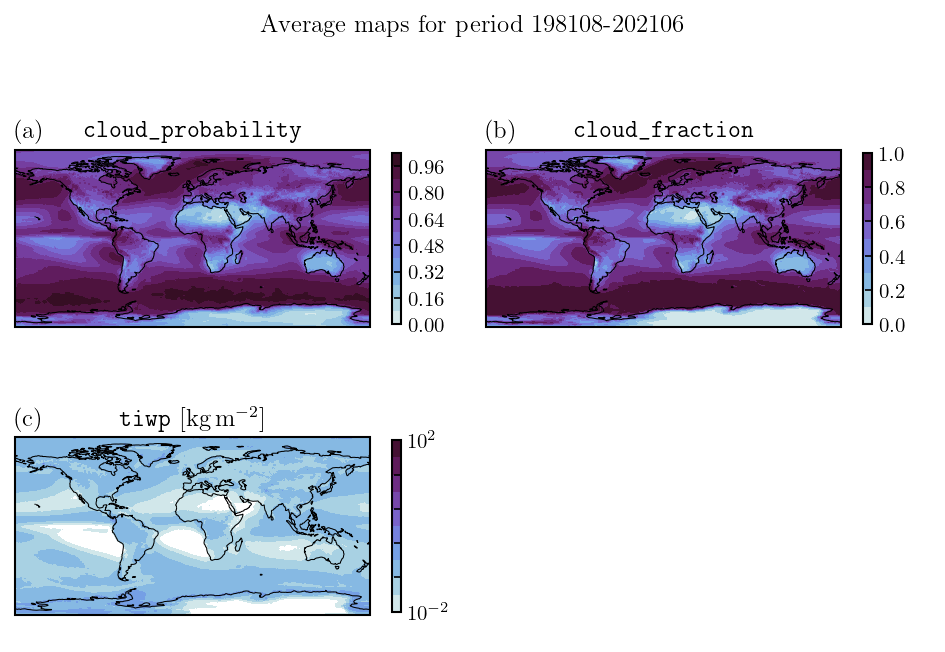

In [8]:
# Second: compute and plot
fig, axs = plt.subplots(ncols=2, nrows=2, subplot_kw=dict(projection=ccrs.PlateCarree()))

step = 10

var = 'cloud_probability'
m_cloud_probability = axs[0,0].contourf(
    ds_results.longitude.data[::step],
    ds_results.latitude.data[::step],
    ds_results[f'{var}_fullaverage'].data[::step, ::step],
    transform=ccrs.PlateCarree(),
    vmin=0,
    vmax=1,
    levels=11
)
m_cloud_probability.set_rasterized(True)
fig.colorbar(m_cloud_probability, ax=axs[0,0], shrink=0.5)
axs[0,0].set_title(rf'\verb+{var}+', loc='center')

var = 'cloud_fraction'
m_cloud_fraction = axs[0,1].contourf(
    ds_results.longitude.data[::step],
    ds_results.latitude.data[::step],
    ds_results[f'{var}_fullaverage'].data[::step, ::step],
    transform=ccrs.PlateCarree(),
    vmin=0,
    vmax=1,
    levels=11
)
m_cloud_fraction.set_rasterized(True)
fig.colorbar(m_cloud_fraction, ax=axs[0,1], shrink=0.5)
axs[0,1].set_title(rf'\verb+{var}+', loc='center')

norm = LogNorm(1e-2, 1e2, clip=True)
levels = np.logspace(-2, 2, 11)

var = 'tiwp'
m_tiwp = axs[1,0].contourf(
    ds_results.longitude.data[::step],
    ds_results.latitude.data[::step],
    ds_results[f'{var}_fullaverage'].data[::step, ::step] * 1e-3, # Convert to kg/m2
    transform=ccrs.PlateCarree(),
    norm=norm,
    levels=levels
)
m_tiwp.set_rasterized(True)
fig.colorbar(m_tiwp, ax=axs[1,0], shrink=0.5, extend='both')
axs[1,0].set_title(rf'\verb+{var}+ [\si{{\kilo\gram\per\square\metre}}]', loc='center')

axs[1,1].set_axis_off()

for i, ax in enumerate(axs.ravel()[:-1]):
    ax.coastlines()
    ax.set_global()
    ax.set_title(f'({chr(97 + i)})', loc='left')

fig.suptitle(f'Average maps for period {month_start}-{month_end}')

fig.tight_layout()

fig.savefig(f'../figures/PATMOSx_expectedmaps_{month_start}-{month_end}.pdf', bbox_inches='tight')
fig.savefig(f'../figures/PATMOSx_expectedmaps_{month_start}-{month_end}.png', dpi=300, bbox_inches='tight')

plt.show()

In [9]:
for var in ['cloud_probability', 'cloud_fraction', 'tiwp']:
    ds_results = ds_results.merge(
        xr.Dataset(
            data_vars={
                f'{var}_fullcount': (
                    ('latitude', 'longitude'),
                    ds[f"{var}_count"].sum(dim="time", skipna=True).values,
                    {'period': f'{month_start}-{month_end}'}
                )
            },
            coords={
                'latitude': ('latitude', ds.latitude.values),
                'longitude': ('longitude', ds.longitude.values)
            }
        )
    )

/tmp/ipykernel_2583837/617886962.py:12: UserWarning: Rasterization of '<cartopy.mpl.contour.GeoContourSet object at 0x72dd054b6e60>' will be ignored
  c.set_rasterized(True)
/tmp/ipykernel_2583837/617886962.py:12: UserWarning: Rasterization of '<cartopy.mpl.contour.GeoContourSet object at 0x72dd08db0790>' will be ignored
  c.set_rasterized(True)
/tmp/ipykernel_2583837/617886962.py:12: UserWarning: Rasterization of '<cartopy.mpl.contour.GeoContourSet object at 0x72dd08db61a0>' will be ignored
  c.set_rasterized(True)


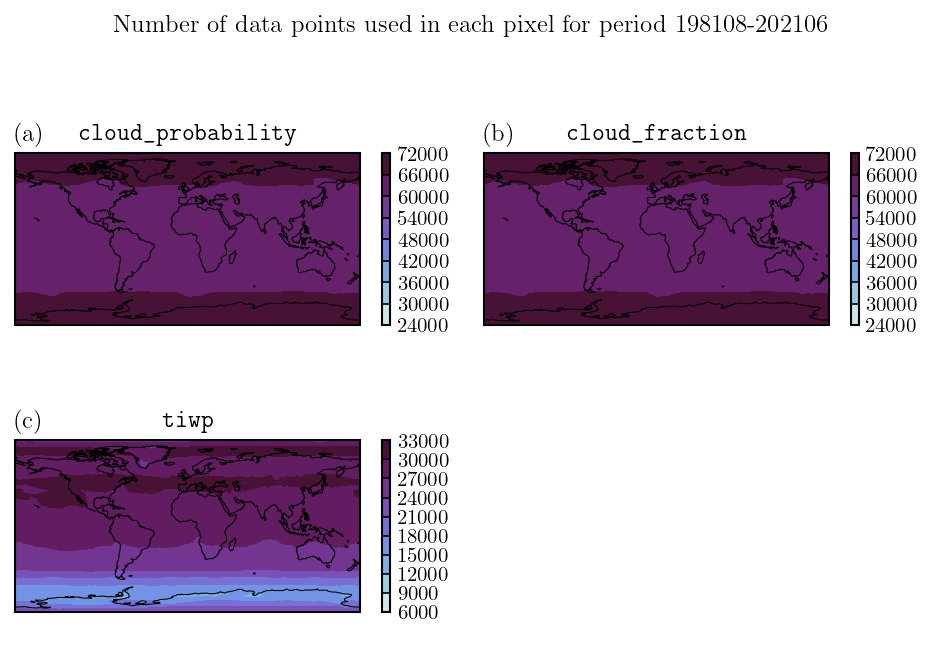

In [10]:
fig, axs = plt.subplots(ncols=2, nrows=2, subplot_kw=dict(projection=ccrs.PlateCarree()))

step = 10

for i, (ax, var) in enumerate(zip(axs.ravel(), ['cloud_probability', 'cloud_fraction', 'tiwp'])):
    c = ax.contourf(
        ds_results.longitude.data[::step],
        ds_results.latitude.data[::step],
        ds_results[f"{var}_fullcount"].data[::step, ::step],
        transform=ccrs.PlateCarree()
    )
    c.set_rasterized(True)
    fig.colorbar(c, ax=ax, shrink=0.5)
    ax.coastlines()
    ax.set_global()
    ax.set_title(f'({chr(97 + i)})', loc='left')
    ax.set_title(rf'\verb+{var}+', loc='center')

axs.ravel()[-1].set_axis_off()

fig.suptitle(f'Number of data points used in each pixel for period {month_start}-{month_end}')

fig.tight_layout()

fig.savefig(f'../figures/PATMOSx_countmaps_{month_start}-{month_end}.pdf', bbox_inches='tight')
fig.savefig(f'../figures/PATMOSx_countmaps_{month_start}-{month_end}.png', dpi=300, bbox_inches='tight')

plt.show()

What is the numerical difference between `cloud_probability` and `cloud_fraction`?

/tmp/ipykernel_2583837/284891687.py:8: UserWarning: Rasterization of '<cartopy.mpl.contour.GeoContourSet object at 0x72dd08e94b80>' will be ignored
  c.set_rasterized(True)


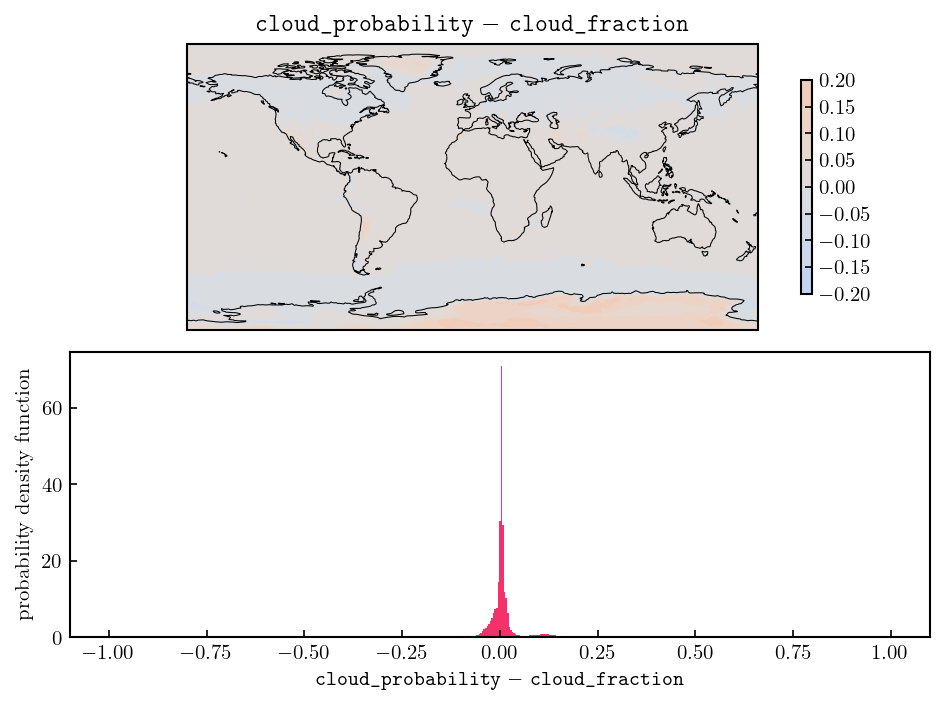

In [11]:
diff = ds_results['cloud_probability_fullaverage'] - ds_results['cloud_fraction_fullaverage']

fig = plt.figure()
gs = fig.add_gridspec(nrows=2)

ax1 = fig.add_subplot(gs[0], projection=ccrs.PlateCarree())
c = ax1.contourf(ds_results.longitude.data[::step], ds_results.latitude.data[::step], diff.data[::10,::10], vmin=-1, vmax=1, cmap='coolwarm', transform=ccrs.PlateCarree())
c.set_rasterized(True)
ax1.set_title(r'\verb+cloud_probability+ $-$ \verb+cloud_fraction+', loc='center')
fig.colorbar(c, ax=ax1, shrink=0.75)
ax1.set_global()
ax1.coastlines()

ax2 = fig.add_subplot(gs[1])
ax2.hist(diff.data.flatten(), bins=np.linspace(-1, 1, 500, endpoint=True), density=True)
ax2.set_xlabel(r'\verb+cloud_probability+ $-$ \verb+cloud_fraction+')
ax2.set_ylabel('probability density function')

fig.tight_layout()

fig.savefig(f'../figures/PATMOSx_diffCPCF_{month_start}-{month_end}.pdf', bbox_inches='tight')
fig.savefig(f'../figures/PATMOSx_diffCPCF_{month_start}-{month_end}.png', dpi=300, bbox_inches='tight')

plt.show()

In [12]:
# As before:
# 1st: (define) computations
# 2nd: save
# 3rd: plot

weights_latitude = np.cos(np.deg2rad(ds_results.latitude))
for var in ['cloud_probability', 'cloud_fraction', 'tiwp']:
    single_weights = weights_latitude
    arr_var_single_weighted = ds[var].weighted(single_weights)
    arr_var_masked_single_weighted = ds[var].where(mask == True).weighted(single_weights)

    double_weights = weights_latitude * ds[f'{var}_count']
    arr_var_double_weighted = ds[var].weighted(double_weights)
    arr_var_masked_double_weighted = ds[var].where(mask == True).weighted(double_weights)

    ds_results = ds_results.merge(
        xr.Dataset(
            data_vars={
                f'{var}_typeIaverage': (
                    'time', arr_var_single_weighted.mean(dim=('longitude', 'latitude'), skipna=True).data
                ),
                f'{var}_typeIaverage_masked': (
                    'time', arr_var_masked_single_weighted.mean(dim=('longitude', 'latitude'), skipna=True).data
                ),
                f'{var}_typeIIaverage': (
                    'time', arr_var_double_weighted.mean(dim=('longitude', 'latitude'), skipna=True).data
                ),
                f'{var}_typeIIaverage_masked': (
                    'time', arr_var_masked_double_weighted.mean(dim=('longitude', 'latitude'), skipna=True).data
                ),
            },
            coords={
                'time': ds.time.data
            }
        )
    )

In [13]:
time_month = np.array([pd.Timestamp(t).month for t in ds.time.data])
for var in ['cloud_probability', 'cloud_fraction', 'tiwp']:
    arr_var_mean_month = []
    for month in range(1, 13):
        ds_month = ds.sel(time=(time_month == month))
        counts_var = ds_month[f'{var}_count']
        arr_var_weighted = ds_month[var].weighted(counts_var)
        arr_var_mean_month.append(arr_var_weighted.mean(dim='time', skipna=True).data.astype(np.float32))

    ds_results = ds_results.merge(
        xr.Dataset(
            data_vars={
                f'{var}_fullrecord_monthlymean': (
                    ('month', 'latitude', 'longitude'),
                    arr_var_mean_month
                )
            },
            coords={
                'month': range(1, 13),
                'latitude': ds.latitude.data,
                'longitude': ds.longitude.data
            }
        )
    )

In [14]:
time_year = np.array([pd.Timestamp(t).year for t in ds.time.data])
time_year_unique = sorted(np.unique(time_year))
for var in ['cloud_probability', 'cloud_fraction', 'tiwp']:
    arr_var_mean_year = []
    for year in time_year_unique:
        ds_year = ds.sel(time=(time_year == year))
        counts_var = ds_year[f'{var}_count']
        arr_var_weighted = ds_year[var].weighted(counts_var)
        arr_var_mean_year.append(arr_var_weighted.mean(dim='time', skipna=True).data.astype(np.float32))
    
    ds_results = ds_results.merge(
        xr.Dataset(
            data_vars={
                f'{var}_yearly_mean': (
                    ('year', 'latitude', 'longitude'),
                    arr_var_mean_year
                )
            },
            coords={
                'year': time_year_unique,
                'latitude': ds.latitude.data,
                'longitude': ds.longitude.data
            }
        )
    )

In [16]:
# Save results to disk
# but first set data type to save disk space
for var in ds_results:
    if var == 'mask':
        continue
    elif 'count' in var:
        ds_results[var] = ds_results[var].astype(np.uint32)
    else:
        ds_results[var] = ds_results[var].astype(np.float32)

ds_results.to_netcdf(
    f'/scratch/ccic_record/data/PATMOS-x_timeseries{month_start}-{month_end}_notebook_results.nc',
    encoding={
        var: {'zlib': True, 'complevel': 9}
        for var in ds_results
    }
)

In [ ]:
fig, axs = plt.subplots(nrows=4, figsize=(16,6))

ax_cloud, ax_cloud_legend, ax_tiwp, ax_tiwp_legend = axs

alpha = 0.3

for i, var in enumerate(['cloud_probability', 'cloud_fraction']):
    color = f'C{i*4}'
    ax_cloud.plot(
        ds_results.time.data,
        ds_results[f'{var}_typeIaverage'].data,
        color=color,
        label=f'{var} (type I)'
    )

    color = f'C{i*4+1}'
    ax_cloud.plot(
        ds_results.time.data,
        ds_results[f'{var}_typeIaverage_masked'].data,
        color=color,
        label=f'{var}, masked (type I)'
    )

    color = f'C{i*4+2}'
    ax_cloud.plot(
        ds_results.time.data,
        ds_results[f'{var}_typeIIaverage'].data,
        color=color,
        label=f'{var} (type II)'
    )

    color = f'C{i*4+3}'
    ax_cloud.plot(
        ds_results.time.data,
        ds_results[f'{var}_typeIIaverage_masked'].data,
        color=color,
        label=f'{var}, masked (type II)'
    )

ax_cloud.minorticks_on()
ax_cloud.grid(
    which='both',
    alpha=alpha,
    color='grey',
    ls='dotted'
)

ax_cloud_legend.set_axis_off()
ax_cloud_legend.legend(
    handles=ax_cloud.get_legend_handles_labels()[0],
    labels=ax_cloud.get_legend_handles_labels()[1],
    ncols=4,
    loc='center'
)
# ax_cloud.set_ylim(0, 1)

for i, var in enumerate(['tiwp']):
    color = f'C{i*4}'
    ax_tiwp.plot(
        ds_results.time.data,
        ds_results[f'{var}_typeIaverage'].data * 1e-3,
        color=color,
        label=f'{var} (type I)'
    )

    color = f'C{i*4+1}'
    ax_tiwp.plot(
        ds_results.time.data,
        ds_results[f'{var}_typeIaverage_masked'].data * 1e-3,
        color=color,
        label=f'{var}, masked (type I)'
    )

    color = f'C{i*4+2}'
    ax_tiwp.plot(
        ds_results.time.data,
        ds_results[f'{var}_typeIIaverage'].data * 1e-3,
        color=color,
        label=f'{var} (type II)'
    )

    color = f'C{i*4+3}'
    ax_tiwp.plot(
        ds_results.time.data,
        ds_results[f'{var}_typeIIaverage_masked'].data * 1e-3,
        color=color,
        label=f'{var}, masked (type II)'
    )

ax_tiwp.set_ylabel(r'\si{\kilo\gram\per\square\metre}')

ax_tiwp.minorticks_on()
ax_tiwp.grid(
    which='both',
    alpha=alpha,
    color='grey',
    ls='dotted'
)

ax_tiwp_legend.set_axis_off()
ax_tiwp_legend.legend(
    handles=ax_tiwp.get_legend_handles_labels()[0],
    labels=ax_tiwp.get_legend_handles_labels()[1],
    ncols=4,
    loc='center'
)
# ax_tiwp.set_ylim(5e-2, 1e0)
ax_tiwp.set_yscale('log')

fig.suptitle('See notes for the difference between type I and type II')

fig.tight_layout()

fig.savefig(f'../figures/PATMOSx_timeseries_{month_start}-{month_end}.pdf', bbox_inches='tight')
fig.savefig(f'../figures/PATMOSx_timeseries_{month_start}-{month_end}.png', dpi=300, bbox_inches='tight')

plt.show()

Reminder on type I and type II:
- Type I average: average of averages.
  - 1: Compute the monthly average for each pixel
  - 2: Weighted average of these pixelwise monthly averages (weights: $\cos(\text{latitude})$)
- Type II average: average all values.
  - 1: Weighted average all values in the month (weights: $\cos(\text{latitude})$)